In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from itertools import islice
from IPython.display import clear_output
import pytry

Experiment Parameters.

In [37]:
n_dims = 2
len_train = 500
n_epoch = 1
p_seed = 1

**Generate and Save Input Data - Only run once.**

First, we just read the raw data file.  We drop any rows that have N/A data in them.

In [38]:
target_dt = 1.0/30

data = pd.read_csv("multidata.csv", low_memory=False)
x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
labs = np.array(data.iloc[:,443]).astype(str) #array of labels (purple child annotations, engagement) 218/443
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    if i == 180:               # add these three lines
        y[y>0]-=np.pi*2   # add these three lines
        y += np.pi            # add these three lines
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

Here's a helper function to take a window of that data, extract it out, and resample it to a given dt using interpolation.

In [39]:
def extract_pattern(start, end, target_dt): #function to extract consecutive frames with the same label 
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)
    timestamp = np.array(data.iloc[start:end,0]).astype(str)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/target_dt))*target_dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return timestamp, result

Now we find the slices of data that correspond to different labelled events

In [40]:
start=[]
start.append(0)
end=[]
label = []
for i in range(1, (len(labs)-1)):
    if labs[i]!=labs[i-1]:
        start.append(i)
    if labs[i]!=labs[i+1]:
        end.append(i)
        label.append(labs[i])

And then extract all that data out.  Notice that we're extracting it out with a dt of 1/30s, since that's about what the data is stored at.  This means we're not generating huge datasets.

In [41]:
t_noplay=[]
p_noplay=[]
t_goal=[]
p_goal=[]
t_aim=[]
p_aim=[]

for i in range(1,(len(start)-1)):
    try:
        if label[i]==('noplay'):
            ts, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_noplay.append(ts)
            p_noplay.append(pi)
        if label[i]==('goaloriented'):
            ts, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_goal.append(ts)
            p_goal.append(pi)
        if label[i]==('aimless'):
            ts, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_aim.append(ts)
            p_aim.append(pi)
    except IndexError:
        print('empty pattern')

empty pattern


Now we collect all that data together and define training and test sets.

In [42]:
i=0
goal = []
noplay = []
aim = []
for entry in t_goal:
    goal.append([t_goal[i],p_goal[i]])
    i = i+1
i=0
for entry in t_noplay:
    noplay.append([t_noplay[i],p_noplay[i]])
    i = i+1
i=0
for entry in t_aim:
    aim.append([t_aim[i],p_aim[i]])
    i = i+1
    
np.save('goal.npy', goal)
np.save('noplay.npy', noplay)
np.save('aim.npy', aim)

**End of Generating and Saving Data**

In [43]:
import nengo

goal = list(np.load('goal.npy'))
noplay = list(np.load('noplay.npy'))
aim = list(np.load('aim.npy'))

seed = p_seed #param.p_seed
dt = 0.001
target_dt = 1.0/30
D = n_dims # param.n_dims
classify_score = {}
accuracy = {}

In [44]:
############ randomly split data 80/20 into training and testing sets ############ 
p_goal2 = random.sample(goal, len(goal))
p_noplay2 = random.sample(noplay, len(noplay))
p_aim2 = random.sample(aim, len(aim))
p_aim2 = np.array(p_aim2)

goal_train_ts = np.array(p_goal2[:(int(len(p_goal2)*0.8))]) 
goal_test_ts = np.array(p_goal2[(int(len(p_goal2)*0.8)):]) 
goal_train_list=list(goal_train_ts[:,1])
goal_test_list=list(goal_test_ts[:,1])
goal_train_time=list(goal_train_ts[:,0])
goal_test_time=list(goal_test_ts[:,0])

noplay_train_ts = np.array(p_noplay2[:(int(len(p_noplay2)*0.8))]) 
noplay_test_ts = np.array(p_noplay2[(int(len(p_noplay2)*0.8)):]) 
noplay_train_list=list(noplay_train_ts[:,1])
noplay_test_list=list(noplay_test_ts[:,1])
noplay_train_time=list(noplay_train_ts[:,0])
noplay_test_time=list(noplay_test_ts[:,0])

Unique segments retained in goal_test_list, noplay_test_list.

In [45]:
for p in noplay_train_list:
    if p.size > 0:
        pass
    else:
        noplay_train_list.remove(p)

for p in noplay_test_list:
    if p.size >0:
        pass
    else:
        noplay_test_list.remove(p)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """


Do the PCA (just on the training data)

In [46]:
train_all = np.vstack(goal_train_list+noplay_train_list)
pca_model = PCA(n_components=D).fit(train_all)

train_time_all = np.hstack(goal_train_time+noplay_train_time)
test_time_all = np.hstack(goal_test_time+noplay_test_time)

goal_train_pca = np.vstack([pca_model.transform(p) for p in goal_train_list])
noplay_train_pca = np.vstack([pca_model.transform(p) for p in noplay_train_list])
goal_test_pca = np.vstack([pca_model.transform(p) for p in goal_test_list])
noplay_test_pca = np.vstack([pca_model.transform(p) for p in noplay_test_list])

In [47]:
goal_test_pca2=[]
noplay_test_pca2=[]

for i in range(len(goal_test_list)):
    goal_test_pca2.append(pca_model.transform(goal_test_list[i]))
    
for i in range(len(noplay_test_list)):
    noplay_test_pca2.append(pca_model.transform(noplay_test_list[i]))

For speed reasons, we can control how much of the training and testing data to use

In [48]:
print(len(goal_train_pca))
print(len(noplay_test_pca))

206381
11200


In [49]:
T_train = len_train #param.len_train   # number of seconds to train on for each class
T_test = 100    # number of seconds to test on for each class

goal_train_time2 = [item for sublist in goal_train_time for item in sublist]
noplay_train_time2 = [item for sublist in noplay_train_time for item in sublist]

goal_test_time2 = [item for sublist in goal_test_time for item in sublist]
noplay_test_time2 = [item for sublist in noplay_test_time for item in sublist]

Let's take a look at the training data

In [50]:
N_frames = int(T_train*30)
#training = np.vstack([goal_train_pca[:N_frames], noplay_train_pca[:N_frames]])
train_timestamps = np.hstack([goal_train_time2[:(N_frames*n_epoch)], noplay_train_time2[:(N_frames*n_epoch)]])
#assert len(training) == N_frames*2

N_frames = int(T_test*30)
testing = np.vstack([goal_test_pca[:N_frames], noplay_test_pca[:N_frames]])
test_timestamps = np.hstack([goal_test_time2[:N_frames], noplay_test_time2[:N_frames]])
assert len(testing) == N_frames*2

Feed the training data into the network and record what information would be fed into the pool.

Run Number:  2
Testing with 80% Training Data


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

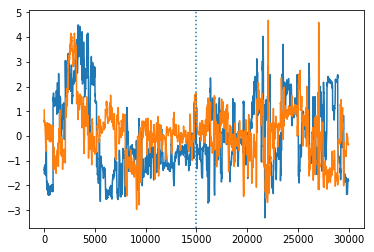

In [51]:
############ TRAINING WITH 80% ############ 
print('Run Number: ', int(p_seed)+1)
print('Testing with 80% Training Data')

num_epochs = n_epoch #param.n_epoch
batch_size = int(T_train*30)
batch = 0
theta = 15

for epoch in range(num_epochs):
    training = np.vstack([goal_train_pca[batch:int(batch+batch_size)], noplay_train_pca[batch:int(batch+batch_size)]])
    batch += batch_size

    net = nengo.Network(seed=seed)#param.seed)
    with net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))


        node_pool = nengo.Node(None, size_in=rw[0].state.size_out*D)

        start = 0
        for r in rw:
            nengo.Connection(r.state, node_pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_node_pool = nengo.Probe(node_pool, sample_every = 0.1)


    sim = nengo.Simulator(net)
    with sim:
        sim.run(T_train*2)  


    pool_model = nengo.Network()
    with pool_model:
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)
    pool_sim = nengo.Simulator(pool_model)

    import nengo.utils.ensemble

    _, a = nengo.utils.ensemble.tuning_curves(pool, pool_sim, inputs=sim.data[p_node_pool])

    if epoch == 0:
        a_goal = a[:(int(len(a)/2))]
        a_noplay = a[(int(len(a)/2)):]
    else:
        a_goal = np.concatenate((a_goal, a[:(int(len(a)/2))]))
        a_noplay = np.concatenate((a_noplay, a[(int(len(a)/2)):]))

a_out = np.vstack([a_goal, a_noplay])

plt.plot(training)
plt.axvline(int(len(training)/2), ls=':')

And let's compute a decoder

In [52]:
N = int((len(a_out))/2) #int(T_train*1000)
target = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)
dec, info = nengo.solvers.LstsqL2(reg=0.1)(a_out, target)

How well does that decoder do?   We could compute rmse, but instead of that let's do classification accuracy.

Text(0.5,1,'training classification accuracy: 99.29%')

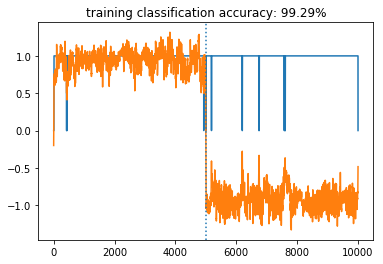

In [53]:
v = np.dot(a_out, dec)
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score_train = np.mean(classify)

classify_score[0]=score_train

train_timestamps = train_timestamps[0::2]


'''output_train = {}
for i in range(len(a_out)):
    output_train[i]={"time":train_timestamps[i], "out_train":v[i]}

for j in range(len(output_train)):        
    key_j = 'output_train{}'.format("%06d" % j)  
    output_train[key_j] = output_train.pop(j)  ''' 

plt.plot(classify)
plt.plot(v)
plt.axvline(int(len(classify)/2), ls=':')
plt.title('training classification accuracy: %1.2f%%' % (score_train*100))

Text(0.5,1,'No Play Training')

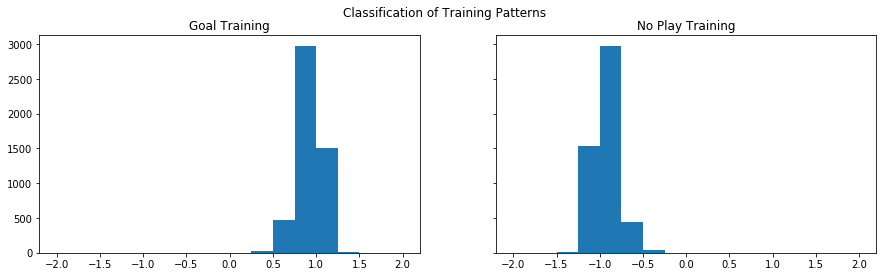

In [54]:
bins=np.arange(-2, 2 + 0.25, 0.25)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
f.suptitle('Classification of Training Patterns')
ax1.hist(v[:N], bins=bins, label='goal training')
ax1.set_title('Goal Training')
ax2.hist(v[N:], bins=bins, label='noplay training')
ax2.set_title('No Play Training')

**Testing the old way - line up several segments**

Now let's run it on the test set.  We combine the rolling window, the pool, and the decoder into one model.

In [55]:
############ TESTING WITH 20% ############ 
print('Testing with 20% Testing Data')

test_net = nengo.Network(seed=seed)#param.seed)
with test_net:
    rw = []
    for i in range(D):
        process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                   presentation_time=1.0/30)
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.Direct()))


    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=seed)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out



    stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)

    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

    p_test_result_sample = nengo.Probe(result, sample_every = 0.1)


test_sim = nengo.Simulator(test_net)
test_sim.run(T_test*2)

Testing with 20% Testing Data


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 13.85%')

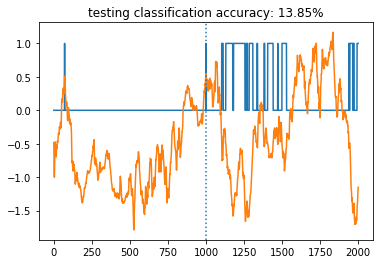

In [56]:
N = int(T_test*10)

v = test_sim.data[p_test_result_sample]
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score_test = np.mean(classify)

classify_score[1]=score_test

test_timestamps = test_timestamps[0::2]

'''output_test = {}
for i in range(len(v)):
    output_test[i]={"time":test_timestamps[i], "out_test":v[i]}

for j in range(len(output_test)):        
    key_j = 'output_test{}'.format("%06d" % j)  
    output_test[key_j] = output_test.pop(j) '''
    
plt.plot(classify)
plt.plot(v)
plt.axvline(int(len(classify)/2), ls=':')
plt.title('testing classification accuracy: %1.2f%%' % (score_test*100))

Text(0.5,1,'No Play Testing')

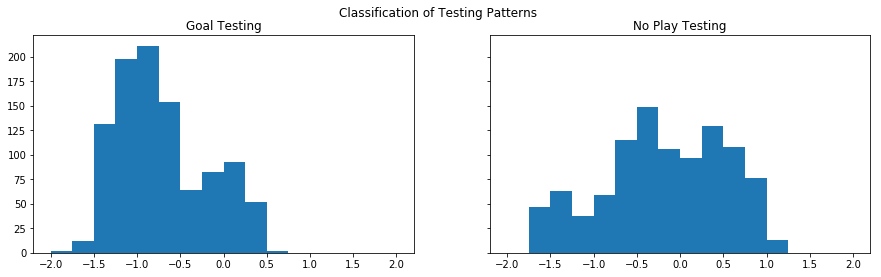

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
f.suptitle('Classification of Testing Patterns')
ax1.hist(v[:N], bins=bins, label='goal testing')
ax1.set_title('Goal Testing')
ax2.hist(v[N:], bins=bins, label='noplay testing')
ax2.set_title('No Play Testing')

**Testing the new way - One segment at a time**

In [58]:
print(len(goal_test_pca2))
print(len(noplay_test_pca2))

num_test = 19 #number of testing patterns for 20% and aimless tests

21
19


In [24]:
############ TESTING WITH 20% ############ 
print('Testing with 20% Testing Data')
a_goal=[]
a_noplay=[]

for j in range(num_test):
    print('Testing Goal Pattern ', int(1+j))
    testing = np.vstack([goal_test_pca2[j]])
    
    test_net = nengo.Network(seed=seed)#param.seed)
    with test_net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)

        start = 0
        for r in rw:
            nengo.Connection(r.state, pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_stim = nengo.Probe(stim)

        result = nengo.Node(None, size_in=1)
        nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

        goal_test_result = nengo.Probe(result, sample_every = 0.1)


    test_sim = nengo.Simulator(test_net)
    test_sim.run(int(len(testing))/30)
    
    v = test_sim.data[goal_test_result]
    
    a_goal.append(v)
    
    ####
    print('Testing No Play Pattern ', int(1+j))
    testing = np.vstack([noplay_test_pca2[j]])
    
    test_net = nengo.Network(seed=seed)#param.seed)
    with test_net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)

        start = 0
        for r in rw:
            nengo.Connection(r.state, pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_stim = nengo.Probe(stim)

        result = nengo.Node(None, size_in=1)
        nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

        noplay_test_result = nengo.Probe(result, sample_every = 0.1)


    test_sim = nengo.Simulator(test_net)
    test_sim.run(int(len(testing))/30)
    
    v = test_sim.data[noplay_test_result]
    
    a_noplay.append(v)

Testing with 20% Testing Data
Testing Goal Pattern  1


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  10


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  10


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  11


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  11


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  12


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  12


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  13


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  13


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  15


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  15


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  17


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  17


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  19


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  19


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [109]:
print('Testing with 20% Testing Data')
a_goal=[]

for j in range(int(len(goal_test_pca2))):
    print('Testing Goal Pattern ', int(1+j))
    testing = np.vstack([goal_test_pca2[j]])

    test_net = nengo.Network(seed=seed)#param.seed)
    with test_net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)

        start = 0
        for r in rw:
            nengo.Connection(r.state, pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_stim = nengo.Probe(stim)

        result = nengo.Node(None, size_in=1)
        nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

        goal_test_result = nengo.Probe(result, sample_every = 0.1)


    test_sim = nengo.Simulator(test_net)
    test_sim.run(int(len(testing))/30)

    v = test_sim.data[goal_test_result]

    a_goal.append(v)
    
output_goal_test = {}
for i in range(len(a_goal)):
    output_goal_test[i]=a_goal[i]
    
for j in range(len(output_goal_test)):        
    key_j = 'output_goal_test{}'.format("%03d" % j)  
    output_goal_test[key_j] = output_goal_test.pop(j) 

Testing with 20% Testing Data
Testing Goal Pattern  1


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  10


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  11


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  12


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  13


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  15


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  17


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  19


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  20


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Goal Pattern  21


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [233]:
a_noplay=[]
for j in range(int(len(noplay_test_pca2))):
    print('Testing No Play Pattern ', int(1+j))
    testing = np.vstack([noplay_test_pca2[j]])

    test_net = nengo.Network(seed=seed)#param.seed)
    with test_net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)

        start = 0
        for r in rw:
            nengo.Connection(r.state, pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_stim = nengo.Probe(stim)

        result = nengo.Node(None, size_in=1)
        nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

        noplay_test_result = nengo.Probe(result, sample_every = 0.1)


    test_sim = nengo.Simulator(test_net)
    test_sim.run(int(len(testing))/30)

    v = test_sim.data[noplay_test_result]

    a_noplay.append(v)
    
output_noplay_test = {}
for i in range(len(a_noplay)):
    output_noplay_test[i]={"time":noplay_test_time[i], "output":a_noplay[i]}
    
for j in range(len(output_noplay_test)):        
    key_j = 'output_noplay_test{}'.format("%03d" % j)  
    output_noplay_test[key_j] = output_noplay_test.pop(j) 

Testing No Play Pattern  1


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  10


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  11


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  12


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  13


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  15


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  17


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing No Play Pattern  19


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

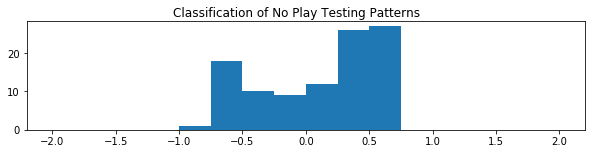

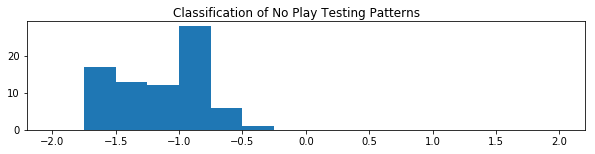

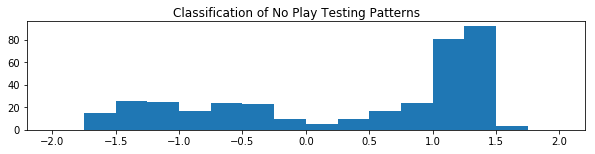

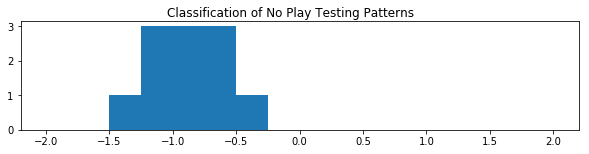

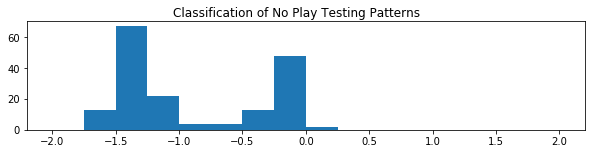

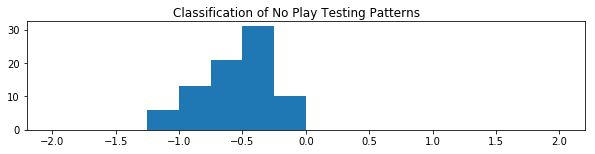

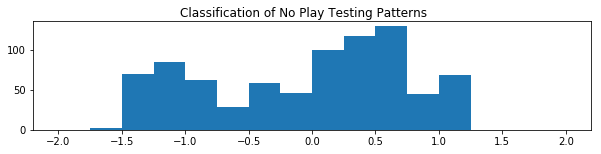

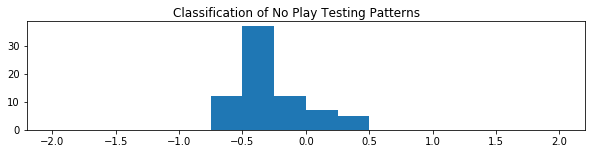

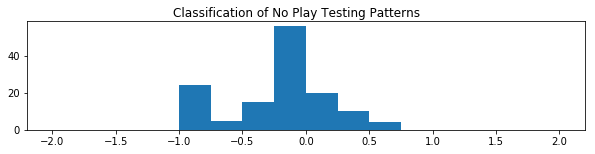

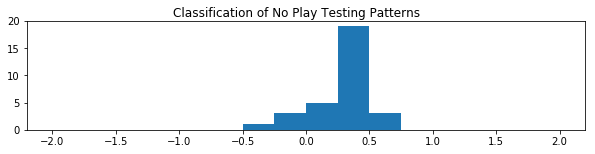

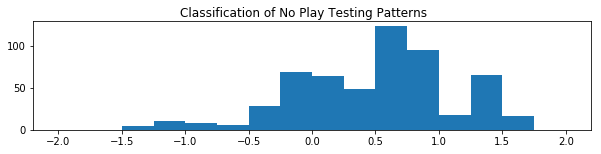

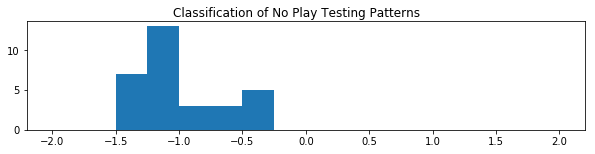

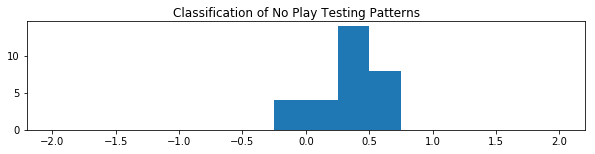

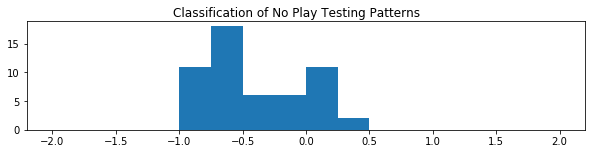

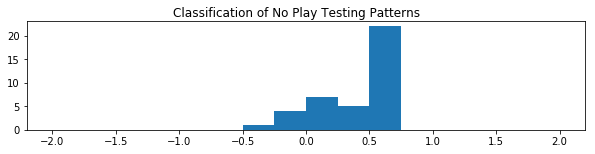

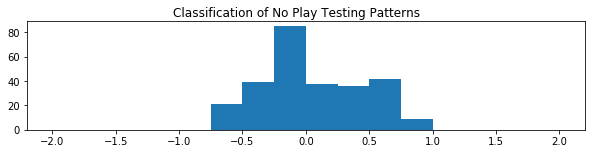

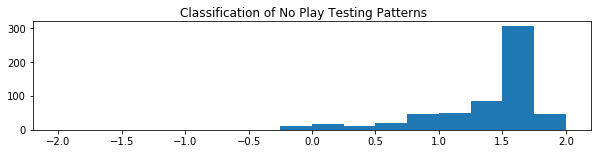

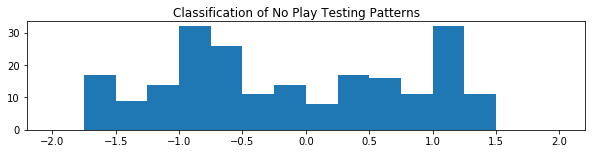

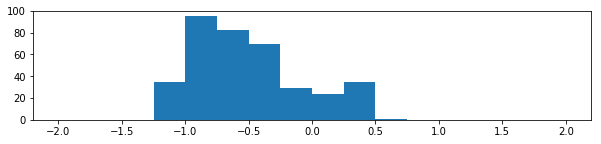

In [26]:
i=1
for r in range(len(a_noplay)):
    plt.suptitle('Classification of No Play Testing Patterns')
    plt.subplots(1, 1, sharey=True, figsize=(10, 2))
    i += 1
    plt.hist(a_noplay[r], bins=bins)
plt.show()

**Back to the Old way of testing for Aimless Patterns**

Now we test on the aimless patterns where the output should be around 0.

In [27]:
############ TESTING WITH AIMLESS PATTERNS ############ 
#p_aim = random.sample(p_aim, len(p_aim))

#aim_train_pca = np.vstack([pca_model.transform(p) for p in p_aim])

#A_len = int(len(aim_train_pca)/30) #Testing on full aimless data
#print(A_len)

#N_frames = T_test*30

#test_aim = np.vstack([aim_train_pca[:N_frames]])
#assert len(test_aim) == N_frames

aim_list=list(p_aim2[:,1])
aim_time=list(p_aim2[:,0])
aim_time_all = np.hstack(aim_time)

aim_train_pca = np.vstack([pca_model.transform(p) for p in aim_list])
aim_time2 = [item for sublist in aim_time_all for item in sublist]

N_frames = T_test*30
test_aim = np.vstack([aim_train_pca[:N_frames]])
assert len(test_aim) == N_frames

aim_timestamps = np.hstack([aim_time2[:N_frames]])

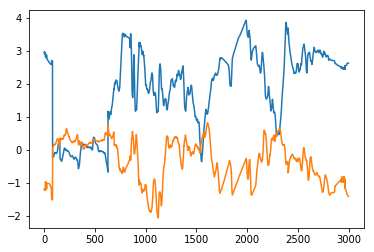

In [28]:
plt.plot(test_aim)

In [29]:
aim_test_net = nengo.Network(seed=seed)#param.seed)
with aim_test_net:
    rw = []
    for i in range(D):
        process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                   presentation_time=1.0/30)
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.Direct()))


    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=seed)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out



    stim = nengo.Node(nengo.processes.PresentInput(test_aim, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)

    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

    p_aim_result_sample = nengo.Probe(result, sample_every=0.1)


aim_test_sim = nengo.Simulator(aim_test_net)
aim_test_sim.run(T_test)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 19.10%')

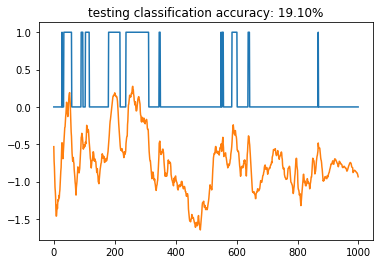

In [30]:
v = aim_test_sim.data[p_aim_result_sample]
classify = np.isclose(v, 0, atol=0.5)
score_aim = np.mean(classify)

classify_score[2]=score_aim
    
plt.plot(classify)
plt.plot(v)
plt.title('testing classification accuracy: %1.2f%%' % (score_aim*100))

Text(0.5,1,'Aimless')

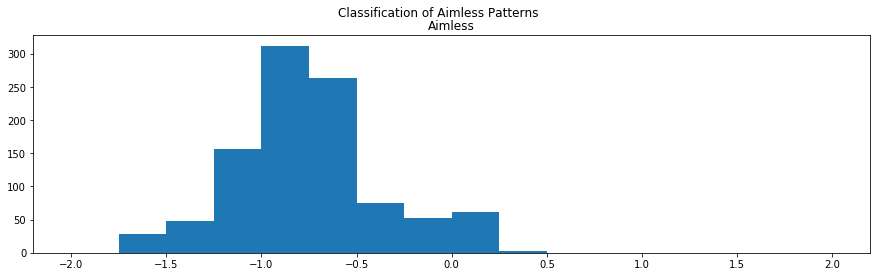

In [31]:
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(15, 4))
f.suptitle('Classification of Aimless Patterns')
ax1.hist(v, bins=bins, label='aimless testing')
ax1.set_title('Aimless')

**And now the New, one segment at a time test for Aimless Patterns**

In [32]:
aim_test_pca2=[]

for i in range(len(aim_list)):
    aim_test_pca2.append(pca_model.transform(aim_list[i]))
    
print(len(aim_test_pca2))

52


In [33]:
############ TESTING WITH AIMLESS PATTERNS ############ 
print('Testing with Aimless Data')
a_aim=[]

for j in range(num_test):
    print('Testing Aimless Pattern ', int(1+j))
    testing = np.vstack([aim_test_pca2[j]])
    
    aim_net = nengo.Network(seed=seed)#param.seed)
    with aim_net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)

        start = 0
        for r in rw:
            nengo.Connection(r.state, pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_stim = nengo.Probe(stim)

        result = nengo.Node(None, size_in=1)
        nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

        aim_test_result = nengo.Probe(result, sample_every = 0.1)


    test_sim = nengo.Simulator(aim_net)
    test_sim.run(int(len(testing))/30)
    
    v = test_sim.data[aim_test_result]
    
    a_aim.append(v)

Testing with Aimless Data
Testing Aimless Pattern  1


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  10


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  11


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  12


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  13


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  15


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  17


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Testing Aimless Pattern  19


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

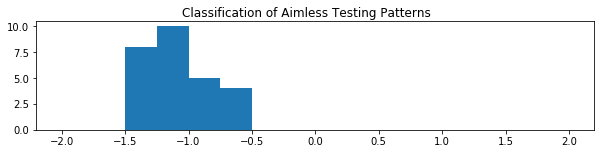

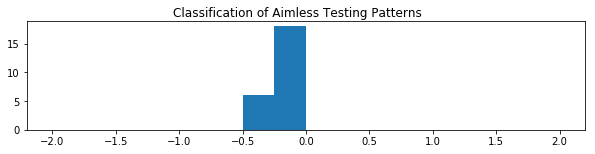

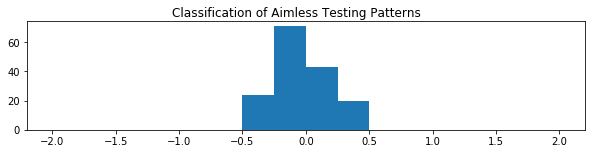

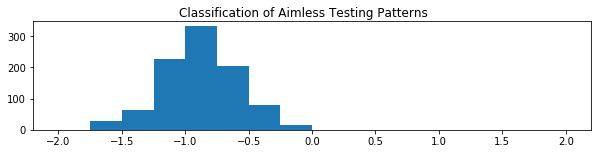

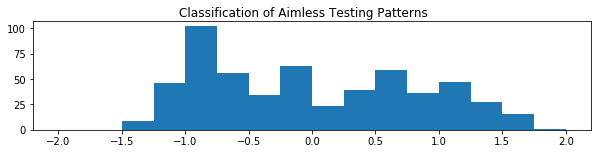

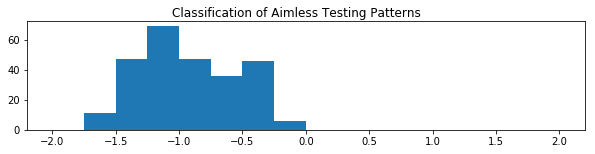

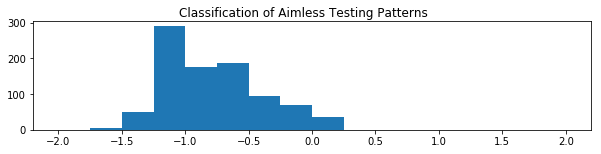

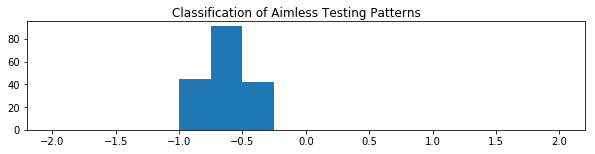

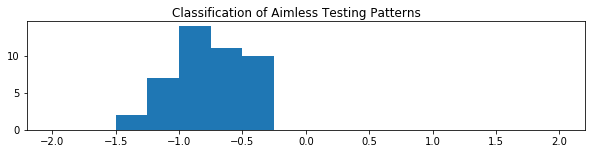

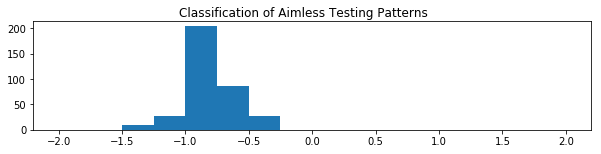

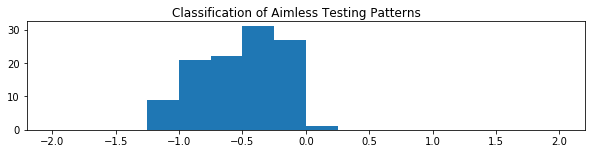

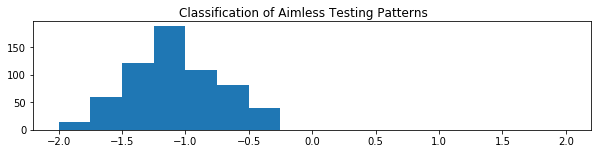

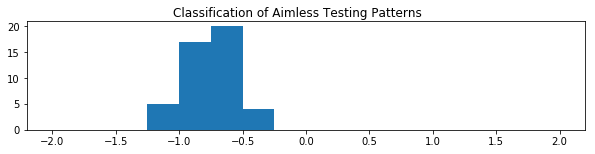

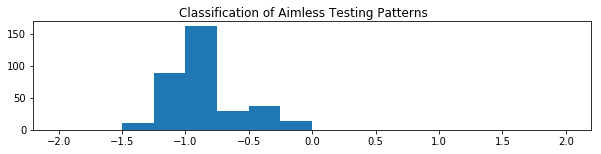

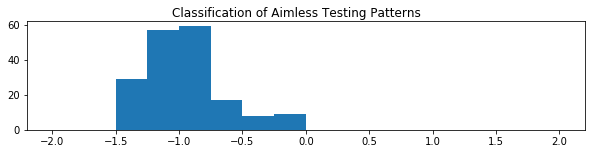

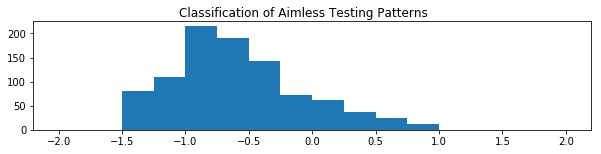

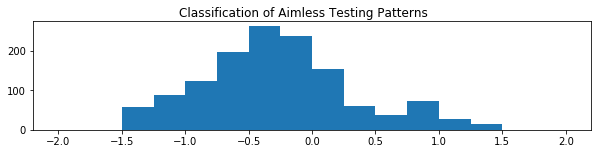

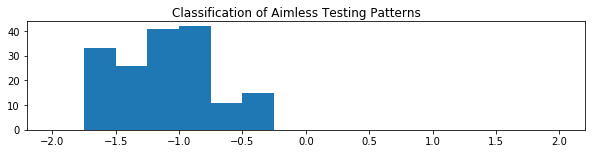

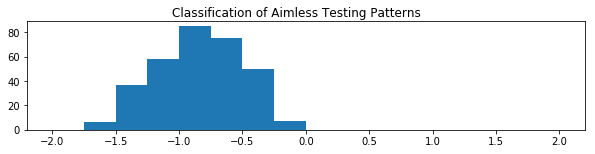

In [34]:
i=1
for r in range(len(a_aim)):
    plt.subplots(1, 1, sharey=True, figsize=(10, 2))
    plt.suptitle('Classification of Aimless Testing Patterns')
    i += 1
    plt.hist(a_aim[r], bins=bins)
plt.show()